# Preprocessing pipeline 

1. [Load data](#load)
2. [Downsample](#downsample)
3. [Filters](#filters)
4. [Find events](#events)
5. [Create epochs](#epochs)
6. [Baseline correction](#baseline) 
7. [Reject bad epochs and channels using the adaptive algorithm](#reject)
8. [ICA](#ica)
   1. [EOG components](#eog)
   2. [ECG components](#ecg)
9. [Interpolate bad channels](#interpolate)
10. [Average reference](#rereference)

In [2]:
%matplotlib qt
import mne
import utils
import matplotlib.pyplot as plt

from cleaner.report import create_ica_report 
from cleaner import reject

from nice_ext.algorithms.adaptive import _adaptive_egi

from autoreject import AutoReject, get_rejection_threshold

Defining ant
Defining ant/124 neighbors
Defining biosemi
Defining bv
Defining egi
Defining egi/256 neighbors
Defining gtec
Defining eximia
Defining eximia/60 neighbors
Defining clinical
Error loading next-icm


# Load data <a name="load"></a>

List of participants: 'VP07';'VP08';'VP09'; 'VP10';'VP11';'VP12';'VP13';'VP14';'VP18';'VP19';'VP20';'VP23';'VP24';'VP25';'VP26';'VP27';'VP28';'VP29';'VP30';'VP31';'VP32';'VP33';'VP35';'VP36';'VP37';

In [3]:
epoch_type = 'evoked'
# epoch_type = 'pseudo-rs'

In [68]:
all_participants = ['VP07','VP08','VP09', 'VP10','VP11','VP12','VP13','VP14','VP18','VP19','VP20','VP23','VP24','VP25','VP26','VP27','VP28','VP29','VP30','VP31','VP32','VP33','VP35','VP36','VP37']
participant = all_participants[1]

path = '/media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/'

folder = path + participant +'/'
file = participant + '_crop_rMean_minmarker.set'

raw = mne.io.read_raw_eeglab(folder+file, preload = True, verbose = False)

<ipython-input-68-25122cd5ff48>:9: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(folder+file, preload = True, verbose = False)


In [69]:
raw.set_channel_types({'EXG3': 'eog', 'EXG4': 'eog', 'EXG5': 'eog','EXG6': 'eog'})

raw.info['bads'] = ['EXG1', 'EXG2', 'EXG7', 'EXG8']

print(raw.info)

<Info | 9 non-empty values
 bads: 4 items (EXG1, EXG2, EXG7, EXG8)
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 68 EEG, 4 EOG
 custom_ref_applied: False
 dig: 72 items (72 EEG)
 highpass: 0.0 Hz
 lowpass: 256.0 Hz
 meas_date: unspecified
 nchan: 72
 projs: []
 sfreq: 512.0 Hz
>


# Downsample <a name="downsample"></a>

In [95]:
raw_downsampled = raw.copy().resample(sfreq=250)

# Filters <a name="filters"></a>

In [96]:
hpass = 0.5
lpass = 45

raw_filtered = raw_downsampled.copy().filter(l_freq=hpass, h_freq=lpass)

In [72]:
fig, ax = plt.subplots(2)

raw_downsampled.plot_psd(ax=ax[0], show=False)
raw_filtered.plot_psd(ax=ax[1], show=False)

ax[0].set_title('PSD before filtering')
ax[1].set_title('PSD after filtering')
ax[1].set_xlabel('Frequency (Hz)')
fig.set_tight_layout(True)
plt.show()

<ipython-input-72-3bb9b0bcd8bd>:3: UserWarning: Infinite value in PSD for channel Pz.
These channels might be dead.
  raw_downsampled.plot_psd(ax=ax[0], show=False)
<ipython-input-72-3bb9b0bcd8bd>:4: UserWarning: Infinite value in PSD for channel Pz.
These channels might be dead.
  raw_filtered.plot_psd(ax=ax[1], show=False)
/home/nicolas.bruno/anaconda3/lib/python3.7/site-packages/ipykernel/eventloops.py:105: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  app.exec_()


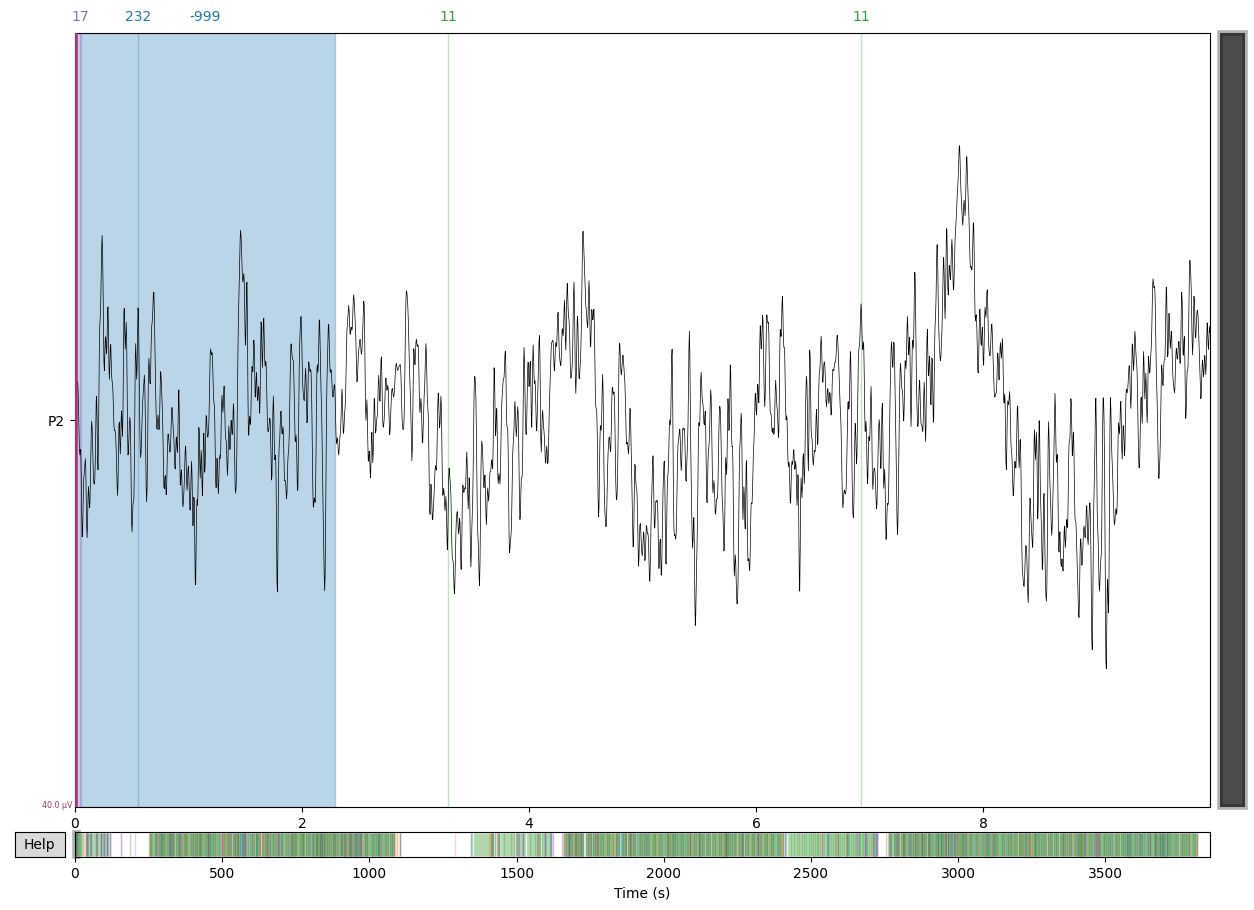

Channels marked as bad: none


In [79]:
raw_filtered.plot()

In [97]:
### Save filtered data
raw_filtered.save(folder + participant + 'filt_raw.fif', overwrite = True)

# Find events <a name="events"></a>

In [98]:
events, event_dict = utils.make_correct_labels(raw_filtered)

Used Annotations descriptions: ['-999', '1', '101', '102', '103', '104', '105', '106', '107', '108', '109', '11', '111', '12', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '17', '171', '173', '181', '191', '192', '2', '201', '202', '203', '204', '205', '206', '207', '208', '232', '233', '234', '238', '239', '251', '252', '253', '255', '3', '4', '5', '6', '7', '74', '80', '86', '9', '92', '99']


# Create Epochs <a name="epochs"></a>

In [12]:
#####EPOCHING#####
def create_epochs(epoch_type, raw, events, event_id, save = False):
    
    if epoch_type == 'evoked':
    
        tmin, tmax = -0.2, 0.6

        baseline = (None,0)
    elif epoch_type == 'pseudo-rs':
        tmin, tmax = -0.8, 0

        baseline = (None,-0.6)
    
    
    epochs = mne.Epochs(raw, events = events, event_id= event_id, baseline = baseline ,
                            tmin = tmin, tmax = tmax, picks = ('eeg', 'eog'), preload = True,
                            verbose = False)
    
    if save == True:
        epochs.save(folder + participant + epoch_type + '_epo.fif', overwrite = True)
    
    return epochs

In [99]:
epochs = create_epochs(epoch_type = epoch_type, raw = raw_filtered, events =  events, event_id = event_dict, save = True)

Overwriting existing file.


# Reject Bad Epochs and Channels <a name="reject"></a>

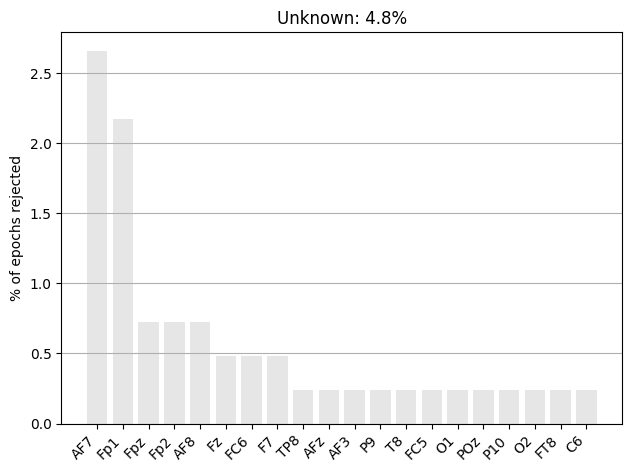

In [100]:
reject_criteria = dict(eeg=150e-6)       # 150 µV
epochs.drop_bad(reject=reject_criteria)
epochs.plot_drop_log()

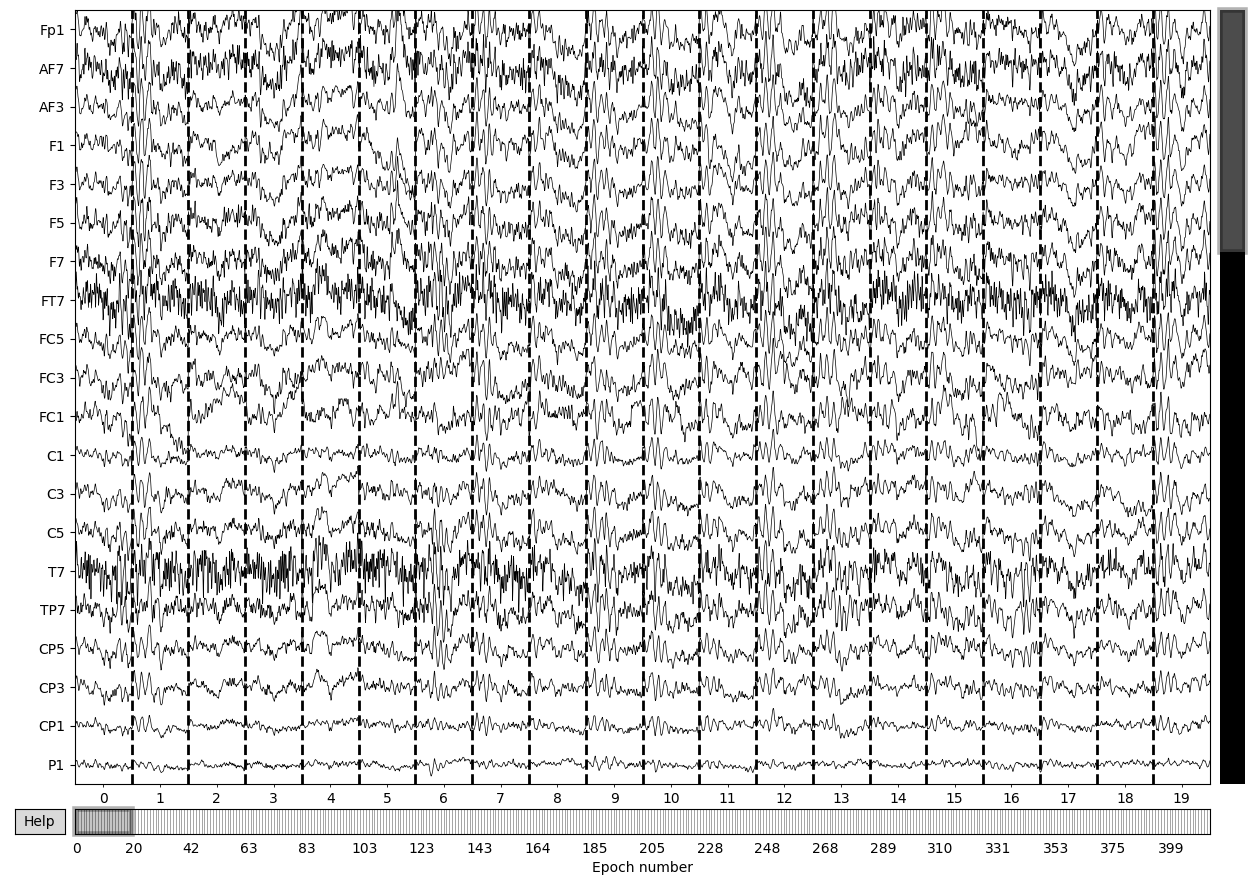

Channels marked as bad: ['EXG1', 'EXG2', 'EXG7', 'EXG8']


In [111]:
epochs.plot()

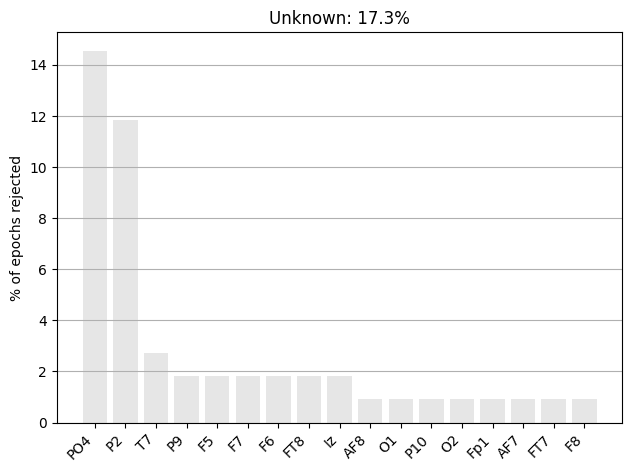

In [16]:
epochs.plot_drop_log()

In [104]:
epochs.save(folder + participant + epoch_type + 'clean_epo.fif', overwrite = True)

Overwriting existing file.


In [18]:
epoched_file = folder + participant + 'evoked' + '_epo.fif'
raw_file =  folder+file 
epochs = mne.read_epochs(folder + participant + 'evoked' + '_epo.fif')
ica = mne.preprocessing.read_ica(folder + participant + '-ica-epo.fif')

Reading /media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/VP07/VP07evoked_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
110 matching events found
No baseline correction applied
0 projection items activated
Reading /media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/VP07/VP07-ica-epo.fif ...
Now restoring ICA solution ...
Ready.


<ipython-input-18-2116fb5c4803>:4: RuntimeWarning: This filename (/media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/VP07/VP07-ica-epo.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica = mne.preprocessing.read_ica(folder + participant + '-ica-epo.fif')


# ICA <a name="ica"></a>

In [106]:
epochs_clean = mne.read_epochs(folder + participant + epoch_type + 'clean_epo.fif')

# epochs_clean.info['bads'].append(['P2', 'PO4'])
epochs_clean.info

Reading /media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/VP08/VP08evokedclean_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     600.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
394 matching events found
No baseline correction applied
0 projection items activated


<Info | 11 non-empty values
 bads: 4 items (EXG1, EXG2, EXG7, EXG8)
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 68 EEG, 4 EOG
 custom_ref_applied: False
 dig: 72 items (72 EEG)
 file_id: 4 items (dict)
 highpass: 0.5 Hz
 lowpass: 45.0 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 72
 projs: []
 sfreq: 250.0 Hz
>

In [107]:
n_components = 0.99  # Should normally be higher, like 0.999!!
method = 'fastica'
max_iter = 512  # Should normally be higher, like 500 or even 1000!!
fit_params = dict(fastica_it=5)
random_state = 42

ica = mne.preprocessing.ICA(n_components=n_components,
                            method=method,
                            max_iter=max_iter,
#                             fit_params=fit_params,
                            random_state=random_state)

ica.fit(epochs_clean)

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by explained variance: 42 components
Fitting ICA took 17.5s.


<ICA | epochs decomposition, fit (fastica): 79194 samples, 42 components, channels used: "eeg">

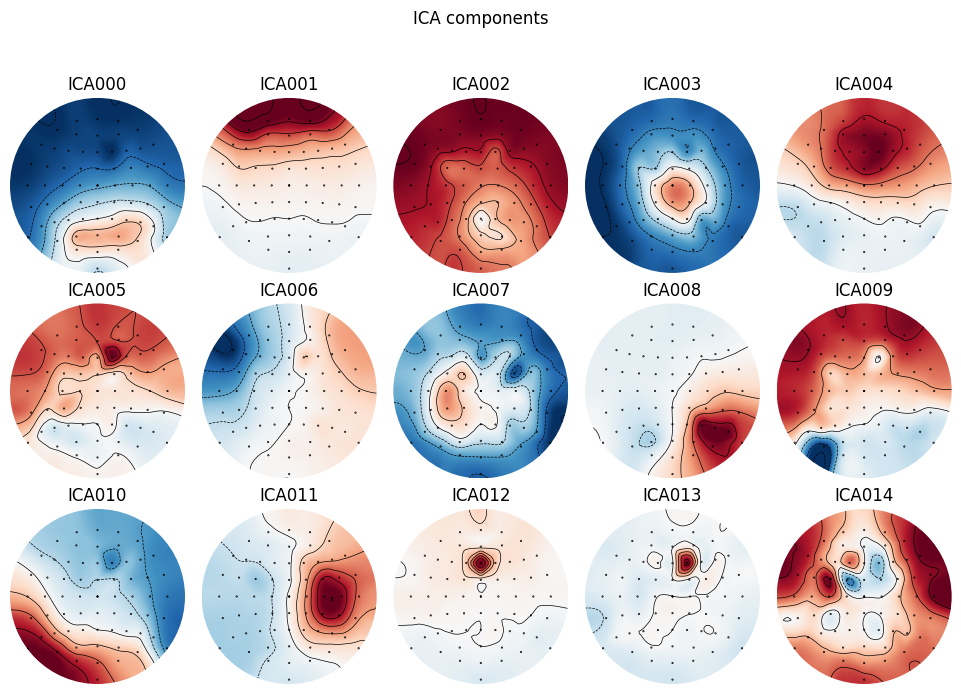

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
394 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
394 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
394 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


In [108]:
# layout = mne.channels.make_eeg_layout(epochs.info)
ica.plot_components(inst = epochs_clean,picks=range(15))

Not setting metadata
Not setting metadata
394 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


<ipython-input-109-26d4a70dbafa>:2: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  ica.plot_sources(epochs_clean, block=True)


    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
394 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
394 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
394 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
394 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
394 matching events found
No baseline correction applied


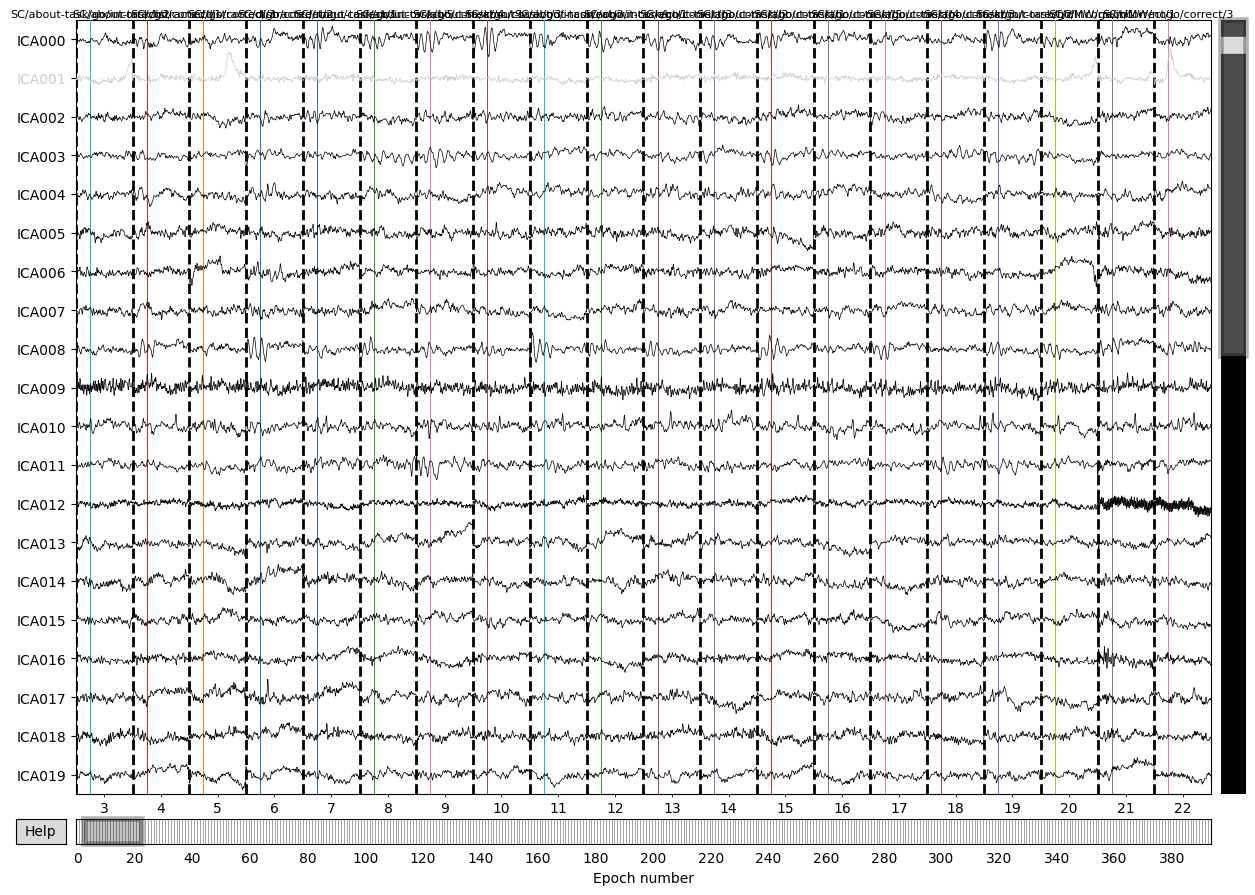

In [109]:
# reject(folder + participant + '-ica-epo.fif', ica)
ica.plot_sources(epochs_clean, block=True)
# ica.plot_properties(epochs)

Applying ICA to Raw instance
    Transforming to ICA space (42 components)
    Zeroing out 1 ICA component
    Projecting back using 64 PCA components


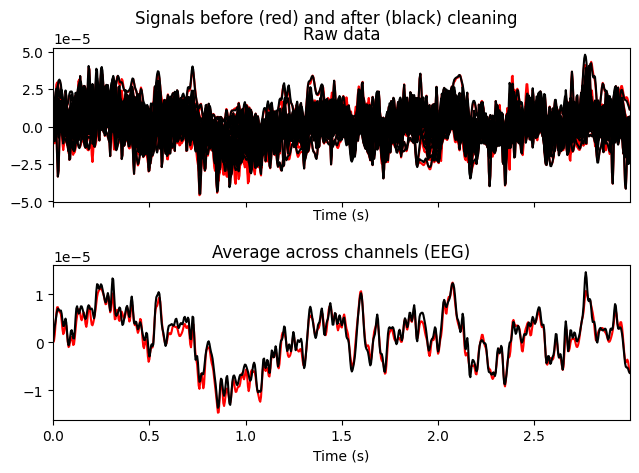

In [110]:
ica.plot_overlay(raw_filtered, exclude=[1])

## Remove EOG <a name="eog"></a>

## Remove ECG <a name="ecg"></a>

# Interpolate bad channels <a name="interpolate"></a>


# Average Rereference <a name="rereference"></a>